# Loan Prediction 05 - Training and Validation of Models with MissForest Imputed Dataset

In [1]:
import math
import sys
sys.path.append('utils')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import metrics_utils 
import model_utils

In [2]:
df_import = pd.read_csv('dataset/train_rf_imputed.csv')
df_import

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Base_Loan_Installment,Remaining_Income
0,1.0,0.0,0.0,0.0,0.0,5849.0,0.0,145.09,360.0,1.0,2.0,1,403.027778,0.931095
1,1.0,1.0,1.0,0.0,0.0,4583.0,1508.0,128.00,360.0,1.0,0.0,0,355.555556,0.941626
2,1.0,1.0,0.0,0.0,1.0,3000.0,0.0,66.00,360.0,1.0,2.0,1,183.333333,0.938889
3,1.0,1.0,0.0,1.0,0.0,2583.0,2358.0,120.00,360.0,1.0,2.0,1,333.333333,0.932537
4,1.0,0.0,0.0,0.0,0.0,6000.0,0.0,141.00,360.0,1.0,2.0,1,391.666667,0.934722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.0,0.0,0.0,0.0,0.0,2900.0,0.0,71.00,360.0,1.0,0.0,1,197.222222,0.931992
566,1.0,1.0,3.0,0.0,0.0,4106.0,0.0,40.00,180.0,1.0,0.0,1,222.222222,0.945879
567,1.0,1.0,1.0,0.0,0.0,8072.0,240.0,253.00,360.0,1.0,2.0,1,702.777778,0.915450
568,1.0,1.0,2.0,0.0,0.0,7583.0,0.0,187.00,360.0,1.0,2.0,1,519.444444,0.931499


In [3]:
columns_x = df_import.drop(columns=['Loan_Status']).columns
column_y = ['Loan_Status']

X_train, X_validation, y_train, y_validation = train_test_split(
    df_import[columns_x], df_import[column_y],  test_size=0.20, random_state=42)

In [4]:
scaler = MinMaxScaler()
scaler.fit(df_import[columns_x])

dump(scaler, 'saves/minmax_scaler_miss_forest_imputation.bin', compress=True)
X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_validation_norm = pd.DataFrame(data=scaler.transform(X_validation),columns=X_train.columns)

In [5]:
X_train_norm.describe()
print(X_train_norm.shape)

(456, 13)


In [6]:
X_validation_norm.describe()
print(X_validation_norm.shape)

(114, 13)


### Logistic Regression Classifier

In [7]:
logistic_regression_params = {
    'C' : [1,10,100,1000],
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

best_lr,best_lr_params,best_lr_score = model_utils.find_best_classification_model_with_cross_validation(
    LogisticRegression(random_state=0, class_weight = 'balanced'),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   21.5s


--- Ellapsed time: 22.206920385360718 seconds ---
Best params:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score (f1) 0.8666376714912432


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   22.0s finished


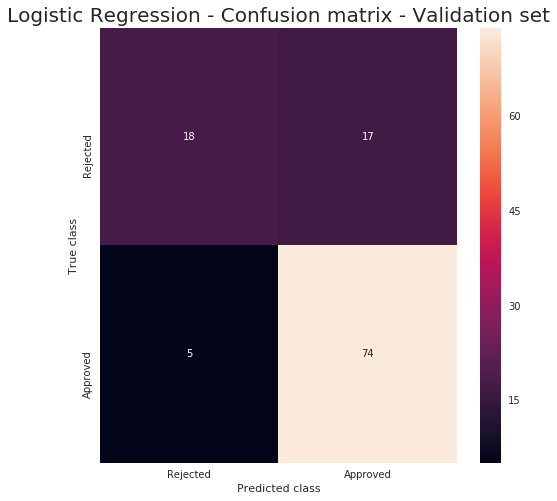

              precision    recall  f1-score   support

    Rejected       0.78      0.51      0.62        35
    Approved       0.81      0.94      0.87        79

    accuracy                           0.81       114
   macro avg       0.80      0.73      0.75       114
weighted avg       0.80      0.81      0.79       114

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.738


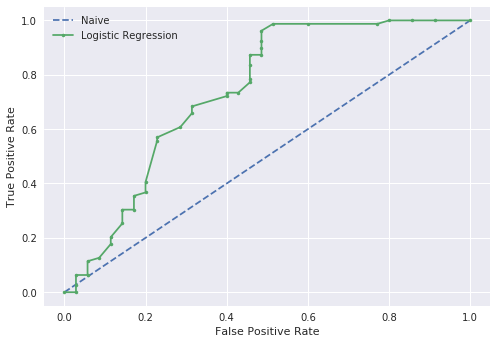

['saves/logistic_regression_miss_forest_imputation.bin']

In [8]:
df_result = model_utils.predict(best_lr,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_lr, 'Logistic Regression',X_validation_norm,y_validation,df_result)
dump(best_lr, 'saves/logistic_regression_miss_forest_imputation.bin', compress=True)

## Ridge Regression

In [9]:
ridge_regression_params = {
    'alpha' : [1,10,100],
    'solver' : ['auto', 'svd', 'lsqr', 'sag', 'cholesky','saga','sparse_cg']
}

best_ridge,best_ridge_params,best_ridge_score = model_utils.find_best_classification_model_with_cross_validation(
    RidgeClassifier(random_state=0, class_weight = 'balanced'),
    ridge_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s


--- Ellapsed time: 2.8536217212677 seconds ---
Best params:  {'alpha': 1, 'solver': 'lsqr'}
Best score (f1) 0.8683898853624396


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.8s finished


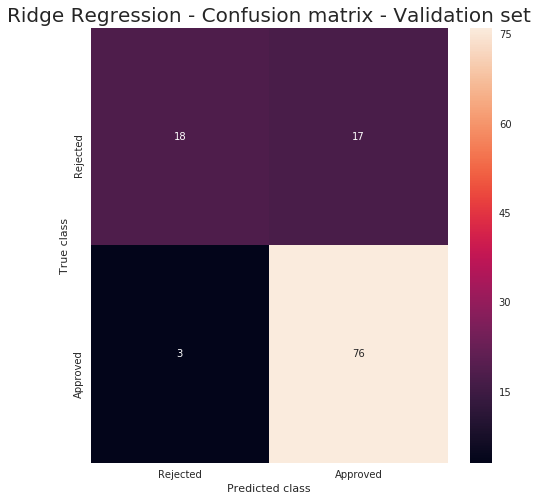

              precision    recall  f1-score   support

    Rejected       0.86      0.51      0.64        35
    Approved       0.82      0.96      0.88        79

    accuracy                           0.82       114
   macro avg       0.84      0.74      0.76       114
weighted avg       0.83      0.82      0.81       114

Could not print ROC AUC curve.


['saves/ridge_regression_miss_forest_imputation.bin']

In [10]:
df_result = model_utils.predict(best_ridge,X_validation_norm,y_validation);
metrics_utils.evalute_model_performance(best_ridge, 'Ridge Regression',X_validation_norm,y_validation,df_result)
dump(best_ridge, 'saves/ridge_regression_miss_forest_imputation.bin', compress=True)

### Random Forest Classifier

In [17]:
random_forest_params = {
    'n_estimators' : [50,100,150,200],
    'min_samples_split': [2,3,4,5],
    'max_depth':[5,8,10,13,15],
    'criterion':['gini','entropy'],
    'oob_score':[True]
}

best_random_forest,best_random_forest_params,best_random_forest_score = model_utils.find_best_classification_model_with_cross_validation(
    RandomForestClassifier(random_state=0, class_weight = 'balanced'),
    random_forest_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:  1.2min


--- Ellapsed time: 83.53361797332764 seconds ---
Best params:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}
Best score (f1) 0.8882301481523414


[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.4min finished


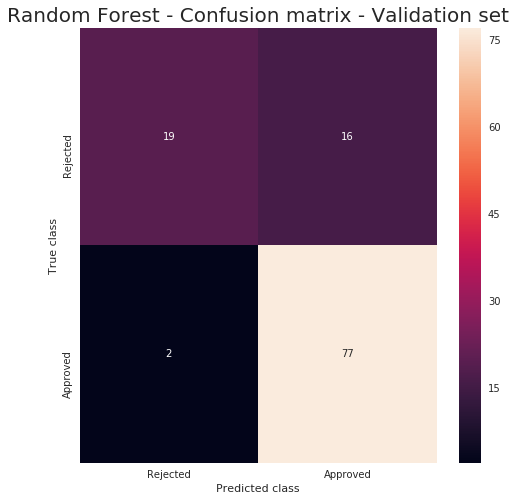

              precision    recall  f1-score   support

    Rejected       0.90      0.54      0.68        35
    Approved       0.83      0.97      0.90        79

    accuracy                           0.84       114
   macro avg       0.87      0.76      0.79       114
weighted avg       0.85      0.84      0.83       114

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.890


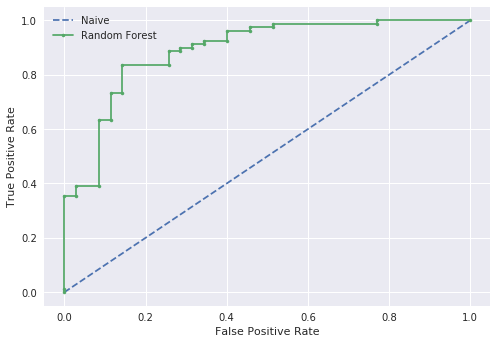

['saves/random_forest_miss_forest_imputation.bin']

In [18]:
df_result = model_utils.predict(best_random_forest,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_random_forest, model_name = 'Random Forest', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_random_forest, 'saves/random_forest_miss_forest_imputation.bin', compress=True)

### Gradient Boosting

In [19]:
gboost_params = {
    'loss':['deviance', 'exponential'],
    'learning_rate':[0.01,0.1],
    'n_estimators' : [50,100,150],
    'min_samples_split': [2,3,4,5],
    'max_depth':[2,3,5,8]
}

best_gboost,best_gboost_params,best_gboost_score = model_utils.find_best_classification_model_with_cross_validation(
    GradientBoostingClassifier(random_state=0),
    gboost_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1626 tasks      | elapsed:   52.7s


--- Ellapsed time: 68.19565987586975 seconds ---
Best params:  {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best score (f1) 0.8869391226586574


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.1min finished


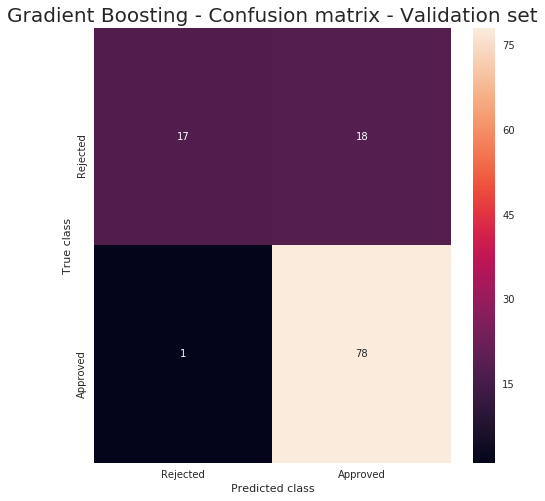

              precision    recall  f1-score   support

    Rejected       0.94      0.49      0.64        35
    Approved       0.81      0.99      0.89        79

    accuracy                           0.83       114
   macro avg       0.88      0.74      0.77       114
weighted avg       0.85      0.83      0.81       114

No Skill: ROC AUC=0.500
Gradient Boosting : ROC AUC=0.805


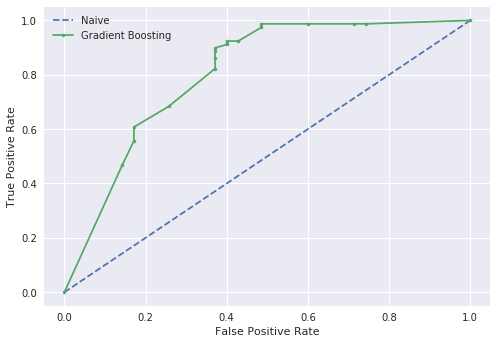

['saves/gradient_boosting_miss_forest_imputation.bin']

In [20]:
df_result = model_utils.predict(best_gboost,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_gboost, model_name = 'Gradient Boosting', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_gboost, 'saves/gradient_boosting_miss_forest_imputation.bin', compress=True)

### Extreme Gradient Boosting

In [21]:
xgb_params = {'objective':['binary:logistic'],
              'learning_rate': [0.1,0.3,0.5],
              'gamma':[0,1],
              'max_depth': [3,4,6,10],
              'subsample': [0.5, 1],
              'n_estimators': [50,100,150],
              'missing':[-999]}

best_xgb,best_gboost_params,best_gboost_score = model_utils.find_best_classification_model_with_cross_validation(
    XGBClassifier(seed=0),
    xgb_params,
    X_train_norm.values,
    y_train.values.ravel(),
    metric = 'f1')

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   15.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   15.5s finished


--- Ellapsed time: 15.496702432632446 seconds ---
Best params:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'missing': -999, 'n_estimators': 50, 'objective': 'binary:logistic', 'subsample': 1}
Best score (f1) 0.8833598740392444


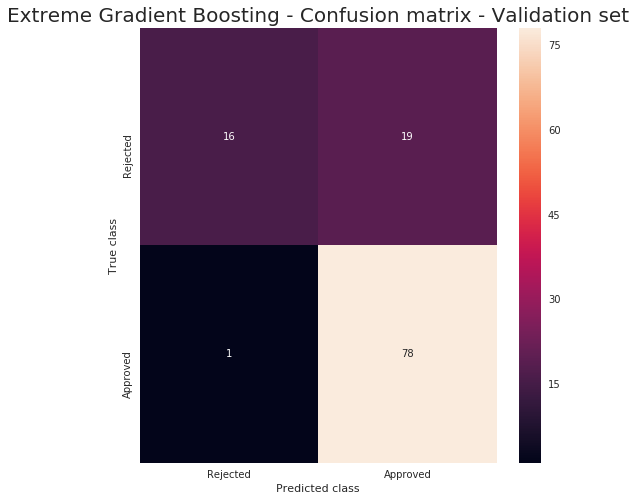

              precision    recall  f1-score   support

    Rejected       0.94      0.46      0.62        35
    Approved       0.80      0.99      0.89        79

    accuracy                           0.82       114
   macro avg       0.87      0.72      0.75       114
weighted avg       0.85      0.82      0.80       114

No Skill: ROC AUC=0.500
Extreme Gradient Boosting : ROC AUC=0.805


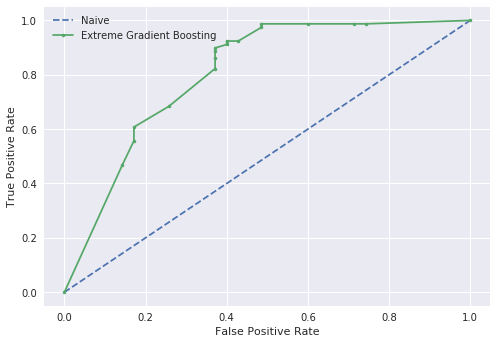

['saves/extreme_gradient_boosting_miss_forest_imputation.bin']

In [22]:
df_result = model_utils.predict(best_xgb,X_validation_norm,y_validation)
metrics_utils.evalute_model_performance(model = best_gboost, model_name = 'Extreme Gradient Boosting', X = X_validation_norm, y = y_validation, df_result = df_result)
dump(best_gboost, 'saves/extreme_gradient_boosting_miss_forest_imputation.bin', compress=True)

## Conclusion

Overall, we can see that all models performed worse when compared to the manual data imputation.
